**1. 준비 (GPU T4로 세팅)**

In [ ]:
!nvidia-smi -L || echo "No GPU detected (ok for quick tests)"
!pip -q install "transformers==4.44.0" "datasets==3.0.1" "torch" "sentencepiece" \
                 "pandas" "numpy" "matplotlib" "tqdm" "evaluate"

GPU 0: Tesla T4 (UUID: GPU-2eac2bc4-b193-a67a-b084-861c18f70ed5)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 61.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


**2. Github Link 추가하여 데이터 불러오기, 데이터 파일 명만 추가하여 파일 구분**

In [ ]:
import pandas as pd

# GitHub raw URL 목록
urls = [
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round1_Bahrain.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round3_Australia.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round4_Japan.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round7_Italy.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round10_Spain.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round12_UnitedKingdom.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round13_Hungary.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round15_Netherlands.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round17_Singapore.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round22_USA.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round23_Qatar.csv",
    "https://raw.githubusercontent.com/hyunseo-adastra/SocialData_SportsCommunity/main/F1_forKCElectra/Round24_AbuDhabi.csv"
]

dfs = []

for url in urls:
    # 파일 이름만 추출 (예: Round1_Bahrain.csv → Round1_Bahrain)
    filename = url.split("/")[-1].replace(".csv", "")

    # CSV 읽기
    df = pd.read_csv(url)

    # 파일 이름 컬럼 추가
    df["source_file"] = filename

    dfs.append(df)

# 모든 데이터 합치기
df_all = pd.concat(dfs, ignore_index=True)

**3. 데이터 컬럼 선택 및 클리닝**

클리닝
- 디시인사이드의 경우 "dc official App" 삭제
- 해시태그, 멘션, URL, 공백 삭제
- "ㅋㅋㅋ"나 "!!!" 등의 표현 수는 남겨두기

**추후논의하여 클리닝 수정 가능

In [ ]:
import pandas as pd
import numpy as np
import re

# 컬럼 찾아내기
TEXT_CAND = [
    "text","content","message","body","comment","chat",
    "post_content","post_text","desc","description"
]
TITLE_CAND = ["title","post_title","subject","headline"]
TIME_CAND = [
    "timestamp","time","created_at","createdAt","date","datetime",
    "post_timestamp","post_time","post_date","published_at","created"
]
GROUP_CAND = ["team","team_name","driver","player","user","author","username"]

def pick_col(cols, cand_list):
    cols_set = set(cols)
    # 1) 정확히 일치
    for c in cand_list:
        if c in cols_set:
            return c
    # 2) 부분 포함(대소문자 무시)
    for col in cols:
        for k in cand_list:
            if k.lower() in col.lower():
                return col
    return None

# 텍스트 결합(제목+본문)도 지원하기 위해 보조 함수
def pick_text_columns(cols):
    text_col = pick_col(cols, TEXT_CAND)
    title_col = pick_col(cols, TITLE_CAND)
    return text_col, title_col

# ---------------------------------------------------------------------
# 데이터 클리닝
# "dc official app" 변형 전부 제거 (따옴표/하이픈/대소문자/앞뒤공백 포함)
_DC_OFFICIAL_PAT = re.compile(
    r"""
    ^\s*        # 라인 시작 공백
    [\-\–\—\u2013\u2014]*\s*   # 하이픈 류와 공백(선택)
    ["']?\s*    # 따옴표(선택)
    d\s*c\s*o\s*f\s*f\s*i\s*c\s*i\s*a\s*l\s*a\s*p\s*p # dc official app(문자 사이 공백 허용 대비)
    \s*["']?    # 따옴표(선택)
    \s*$        # 라인 끝
    """,
    re.IGNORECASE | re.VERBOSE
)

def remove_dc_official_app_lines(s: str) -> str:
    """문장 중 개별 라인으로 들어온 '- dc official App' 류 라인을 날림."""
    # 줄 단위로 쪼개서 해당 패턴에 맞는 줄 제거
    lines = re.split(r"[\r\n]+", s)
    kept = [ln for ln in lines if not _DC_OFFICIAL_PAT.match(ln)]
    return "\n".join(kept).strip()

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    # 0) 먼저 dc official app 같은 라인 제거
    s = remove_dc_official_app_lines(s)

    # 1) URL 제거
    s = re.sub(r"http\S+|www\.\S+", " ", s)

    # 2) 멘션/해시태그 제거
    s = re.sub(r"[@#]\w+", " ", s)

    # 생략 3) 반복 문자 축약 (ㅋㅋㅋㅋ -> ㅋㅋ, 아아아아 -> 아아, !!!!! -> !!)
    # s = re.sub(r"([ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9!?.])\1{2,}", r"\1\1", s)

    # 생략 4) 이모지/특수문자 과도한 것 정리 (한글/영문/숫자/기본문장부호만 유지)
    # s = re.sub(r"[^\w\s가-힣ㄱ-ㅎㅏ-ㅣ!?.]", " ", s, flags=re.UNICODE)

    # 생략 5) 팀명/드라이버 약칭 정규화 (원하면 계속 추가)
    # team_map = {
    #    "T1": "티원",
    #    "GEN": "젠지",
    #    "VER": "페르스타펜",
    #    "HAM": "해밀턴",
    #}
    #for short_name, full_name in team_map.items():
    #    s = re.sub(fr"\b{short_name}\b", full_name, s, flags=re.IGNORECASE)

    # 6) 공백 정리
    s = re.sub(r"\s+", " ", s).strip()
    return s

####클리닝은 논의 후 추가

# ---------------------------------------------------------------------
df = df_all.copy()

# 텍스트/제목/시간/그룹 컬럼 자동 선택
TEXT_COL, TITLE_COL = pick_text_columns(df.columns)
TIME_COL = pick_col(df.columns, TIME_CAND)
GROUP_COL = pick_col(df.columns, GROUP_CAND)

print(f"Detected -> TEXT_COL={TEXT_COL}, TITLE_COL={TITLE_COL}, TIME_COL={TIME_COL}, GROUP_COL={GROUP_COL}")

# 텍스트 컬럼이 없으면 제목만이라도 사용, 그것도 없으면 에러
if TEXT_COL is None and TITLE_COL is None:
    raise ValueError("텍스트(채팅/본문/내용) 컬럼을 못 찾았어요. 필요 시 df_raw.rename(columns={'실제컬럼명':'text'}) 후 재실행하세요.")

# 텍스트 결합: 본문+제목 (제목이 있으면 앞에 붙이기)
if TEXT_COL is not None and TITLE_COL is not None:
    df["_raw_text_for_clean"] = (
        df[TITLE_COL].astype(str).fillna("") + " " + df[TEXT_COL].astype(str).fillna("")
    )
elif TEXT_COL is not None:
    df["_raw_text_for_clean"] = df[TEXT_COL].astype(str).fillna("")
else:
    df["_raw_text_for_clean"] = df[TITLE_COL].astype(str).fillna("")

# 클리닝
df["clean_text"] = df["_raw_text_for_clean"].map(normalize_text)

# 타임스탬프 파싱(있으면). 문자열/숫자 혼재 대응 & 실패는 NaT로
if TIME_COL is not None:
    # 숫자형 유닉스 타임스탬프(초/밀리초)일 가능성도 처리
    if np.issubdtype(df[TIME_COL].dtype, np.number):
        # 초/밀리초 구분 추정
        median_val = df[TIME_COL].dropna().astype(float).median() if df[TIME_COL].notna().any() else None
        if median_val and median_val > 1e12:
            # 밀리초로 보임
            df["ts"] = pd.to_datetime(df[TIME_COL], unit="ms", errors="coerce", utc=True).dt.tz_localize(None)
        elif median_val and median_val > 1e9:
            # 초로 보임
            df["ts"] = pd.to_datetime(df[TIME_COL], unit="s", errors="coerce", utc=True).dt.tz_localize(None)
        else:
            # 일반 숫자 -> 문자열 변환 후 파서에 맡김
            df["ts"] = pd.to_datetime(df[TIME_COL].astype(str), errors="coerce")
    else:
        df["ts"] = pd.to_datetime(df[TIME_COL], errors="coerce")
else:
    df["ts"] = pd.NaT

# 빈 텍스트/공백만 남은 행 제거
df["clean_text"] = df["clean_text"].fillna("").str.strip()
df = df[df["clean_text"].astype(bool)].reset_index(drop=True)

# 편의: source_file에서 라운드명 추출
if "source_file" in df.columns:
    # 예: Round22_USA -> round_num=22, gp_name=USA
    m = df["source_file"].str.extract(r"Round\s*([0-9]+)[\s_]+(.+)", expand=True)
    df["round_num"] = pd.to_numeric(m[0], errors="coerce")
    df["gp_name"] = m[1].fillna("").str.replace("_", " ").str.strip()

print("After cleaning, rows:", len(df))
display_cols = ["clean_text","ts"]
if "source_file" in df.columns: display_cols.append("source_file")
if "round_num" in df.columns:   display_cols.append("round_num")
if "gp_name" in df.columns:     display_cols.append("gp_name")
if GROUP_COL is not None:       display_cols.append(GROUP_COL)
print(df[display_cols].head(10))

Detected -> TEXT_COL=post_content, TITLE_COL=post_title, TIME_COL=post_timestamp, GROUP_COL=None
After cleaning, rows: 43134
                              clean_text                  ts     source_file  \
0                     와 존나설레 ㅅㅂ 가보자고ㅜㅜㅜㅡ 2024-03-03 00:04:04  Round1_Bahrain   
1                      스포한다 물탕이가 르끌레 꽂는다 2024-03-03 00:04:06  Round1_Bahrain   
2        라마단 <<< 고마우면 개추 ㅋㅋㅋ 덕분에 편하게본다 ㅆ 2024-03-03 00:04:09  Round1_Bahrain   
3              와 씹 진짜 저 초록색 흉물 좆같네 ㅅㅂㅋㅋㅋ 2024-03-03 00:04:10  Round1_Bahrain   
4                   개ㅈ핀 도착 ㅋㅋㅋㅋㅋㅋㅋㅋㅋ nan 2024-03-03 00:04:07  Round1_Bahrain   
5                  ㅋㅋㅋ 알핀이 마지막ㅋㅋㅋㅋ ㅋㅋㅋㅋㅋ 2024-03-03 00:04:11  Round1_Bahrain   
6  It's lights out and away we go!!! nan 2024-03-03 00:04:14  Round1_Bahrain   
7                          드가좤ㅋㅋㅋㅋㅋㅋ nan 2024-03-03 00:04:15  Round1_Bahrain   
8                          츠노다 가자 ㅋㅋ nan 2024-03-03 00:04:18  Round1_Bahrain   
9                          스타트!!!!!! nan 2024-03-03 00:04:17  Round1_Bahrai

**4. 파인튜닝을 위한 데이터셋 불러오기**

사용데이터: NSMC, Steam
- NSMC 네이버 영화 댓글: https://github.com/e9t/nsmc
- Steam 리뷰: https://github.com/bab2min/corpus

In [ ]:
from datasets import load_dataset, DatasetDict, concatenate_datasets
import pandas as pd

# NSMC (네이버 영화리뷰) 불러오기
nsmc = load_dataset(
    "csv",
    data_files={
        "train": "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
        "test":  "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt",
    },
    delimiter="\t"
)
print("NSMC loaded:", nsmc)

# Steam 한국어 리뷰 데이터 불러오기
# 파일 구조: 각 줄이 "label\ttext" 형태
steam = load_dataset(
    "csv",
    data_files={"train": "https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt"},
    delimiter="\t",
    column_names=["label", "text"]
)
print("Steam dataset loaded:", steam)

# 컬럼 구조 통일
# NSMC는 "document" 컬럼 → text로 이름 변경
nsmc = nsmc.rename_column("document", "text")

# 라벨 타입 통일 (float → int 등)
nsmc["train"] = nsmc["train"].map(lambda x: {"label": int(x["label"])})
nsmc["test"]  = nsmc["test"].map(lambda x: {"label": int(x["label"])})
steam["train"] = steam["train"].map(lambda x: {"label": int(x["label"])})

# Steam train 데이터와 NSMC train/test 합치기
train_merged = concatenate_datasets([nsmc["train"], steam["train"]])
test_merged  = nsmc["test"]  # Steam에는 test 세트가 없으므로 그대로 사용

merged = DatasetDict({"train": train_merged, "test": test_merged})
print("통합 DatasetDict 구성 완료:")
print(merged)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

NSMC loaded: DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


Generating train split: 0 examples [00:00, ? examples/s]

Steam dataset loaded: DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 100000
    })
})


Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

통합 DatasetDict 구성 완료:
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 250000
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 50000
    })
})


**5. KcElectra 모델 불러오기, Tokenizing**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
import evaluate
import torch
import numpy as np

# 모델 후보. 첫 번째가 잘 불리면 그대로 사용.
BASES = ["beomi/KcELECTRA-base", "beomi/KcELECTRA-base-v2022"]

tok = None
MODEL_BASE = None
for base in BASES:
    try:
        tok = AutoTokenizer.from_pretrained(base)
        MODEL_BASE = base
        print("Using base:", base)
        break
    except Exception as e:
        print("Tokenizer load failed:", base, "->", e)

if tok is None:
    raise RuntimeError("KcELECTRA 토크나이저 로드 실패")

def tok_fn(batch):
    # Use the "text" column for tokenization as it's available in the merged dataset
    texts = [str(text) for text in batch["text"]]
    out = tok(texts, truncation=True, max_length=128)
    # Add the label column
    out["labels"] = batch["label"]
    return out


# nsmc 데이터셋 대신 클리닝된 df 데이터프레임을 사용
# 데이터프레임을 Dataset 객체로 변환
from datasets import Dataset
# df_dataset = Dataset.from_pandas(df) # This is not used for training anymore

# tokenized = df_dataset.map(
#     tok_fn,
#     batched=True,
#     # remove_columns는 더 이상 nsmc 데이터셋을 사용하지 않으므로 필요 없습니다.
#     # remove_columns=remove_cols
# )


collator = DataCollatorWithPadding(tokenizer=tok)
metric_f1 = evaluate.load("f1")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_BASE,
    num_labels=2 # 이진 분류 (긍정/부정)를 위한 num_labels=2
)

print("Tokenized dataset structure:", merged) # Print the merged dataset structure

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/514 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Using base: beomi/KcELECTRA-base


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 250000
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 50000
    })
})


**6. KcElectra Model Training(Finetuning)**

In [ ]:
from transformers import TrainingArguments, Trainer

# 훈련 인자 설정
training_args = TrainingArguments(
    output_dir="./results",          # 훈련 결과 및 체크포인트 저장 디렉토리
    evaluation_strategy="epoch",     # 에포크마다 평가 수행
    save_strategy="epoch",           # 에포크마다 모델 저장
    learning_rate=2e-5,              # 학습률
    per_device_train_batch_size=16,  # 장치당 훈련 배치 크기
    per_device_eval_batch_size=16,   # 장치당 평가 배치 크기
    num_train_epochs=3,              # 훈련 에포크 수
    weight_decay=0.01,               # 가중치 감소 (L2 정규화)
    push_to_hub=False,               # Hugging Face Hub에 푸시하지 않음
    report_to="none",                # 로깅 비활성화
)

# 평가 메트릭 함수 정의
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric_f1.compute(predictions=predictions, references=labels)

# Trainer 인스턴스 생성
# 훈련 데이터셋은 수동으로 토큰화한 tokenized_inputs 리스트를 사용합니다.
# 검증 데이터셋은 NSMC 테스트 데이터셋을 사용하여 토큰화해야 합니다.

# NSMC 테스트 데이터셋 토큰화
test_texts = [str(text) for text in nsmc["test"]["text"]]
test_labels = nsmc["test"]["label"]

# The previous tokenization logic was for `df_dataset` which is not the training data.
# The training data should be `merged["train"]` and the evaluation data `merged["test"]`.
# Also, the tokenization should be done using the `map` function of the Dataset object, not manually in a loop.

# Tokenize the merged datasets
tokenized_merged = merged.map(
    tok_fn,
    batched=True,
    remove_columns=["id", "text"] # Remove original text columns after tokenization
)

collator = DataCollatorWithPadding(tokenizer=tok)
metric_f1 = evaluate.load("f1")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_BASE,
    num_labels=2 # 이진 분류 (긍정/부정)를 위한 num_labels=2
)

trainer = Trainer(
    model=model,                         # 훈련할 모델
    args=training_args,                  # 훈련 인자
    train_dataset=tokenized_merged["train"],         # 훈련 데이터셋
    eval_dataset=tokenized_merged["test"],           # 검증 데이터셋
    data_collator=collator,              # 데이터 콜레이터
    compute_metrics=compute_metrics,     # 평가 메트릭 함수
    tokenizer=tok                        # 토크나이저
)

# 훈련 시작
print("Starting training...")
trainer.train()
print("Training finished.")

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/250000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,F1
1,0.295800,0.237991,0.909819
2,0.236200,0.247560,0.910727
3,0.180400,0.327103,0.911701


Training finished.


**7. 감성분석**

In [ ]:
import torch, numpy as np
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import glob

# MODEL_PATH를 훈련 결과가 저장된 디렉토리로 변경
# './results' 디렉토리에 저장된 최신 체크포인트를 로드합니다.
TRAINING_OUTPUT_DIR = "./results"
BASE = "beomi/KcELECTRA-base"                # 토크나이저용 베이스

# 가장 최근 체크포인트 디렉토리를 찾습니다.
checkpoints = [d for d in glob.glob(f"{TRAINING_OUTPUT_DIR}/checkpoint-*") if os.path.isdir(d)]
if not checkpoints:
    raise FileNotFoundError(f"No checkpoint directories found in {TRAINING_OUTPUT_DIR}")

# 체크포인트 이름에서 숫자를 추출하여 최신 체크포인트를 찾습니다.
latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('-')[-1]))
MODEL_PATH = latest_checkpoint
print(f"Loading model from: {MODEL_PATH}")


tok = AutoTokenizer.from_pretrained(BASE)
# 훈련된 모델 로드
clf = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).eval().to("cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"

def batched(lst, n=64):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

probs = []
for chunk in tqdm(batched(df["clean_text"].tolist(), 64), total=(len(df)//64 + 1)):
    enc = tok(chunk, truncation=True, padding=True, max_length=128, return_tensors="pt")
    enc = {k:v.to(device) for k,v in enc.items()}
    with torch.no_grad():
        p = clf(**enc).logits.softmax(dim=-1).cpu().numpy()  # [:,0]=neg, [:,1]=pos
    probs.append(p)

probs = np.vstack(probs)
df["p_neg"], df["p_pos"] = probs[:,0], probs[:,1]
df["polarity_binary"] = (df["p_pos"] > df["p_neg"]).astype(int)  # 1=pos, 0=neg

# 휴리스틱 중립(신뢰도 낮은 샘플)
conf = np.abs(df["p_pos"] - 0.5) * 2  # 0..1
NEUTRAL_THRESH = 0.20                 # 필요시 0.15~0.30에서 튜닝
df["neutral_flag"] = (conf < NEUTRAL_THRESH).astype(int)

def to_ternary(row):
    if row["neutral_flag"] == 1: return 1  # neutral
    return 2 if row["polarity_binary"]==1 else 0  # 2=pos, 0=neg

df["polarity_3cls"] = df.apply(to_ternary, axis=1)
df[["clean_text","p_pos","p_neg","polarity_binary","polarity_3cls"]].head(10)

# 결과 저장
output_path = "/content/F1_sentiment_results.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"저장 완료 → {output_path}")

Loading model from: ./results/checkpoint-46875


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/674 [00:00<?, ?it/s]

저장 완료 ✅ → /content/F1_sentiment_results.csv


**8. 타임스탬프별 감성분석**
- 예시. 시간단위로 수정 필요

,bin,n,mean_pos,std_pos,synchrony_idx
0,14245202,60,0.581318,0.380981,0.619019
1,14245203,43,0.430491,0.407157,0.592843
2,14245204,66,0.545365,0.404850,0.595150
3,14245205,60,0.361852,0.377557,0.622443
4,14245206,57,0.345458,0.411496,0.588504


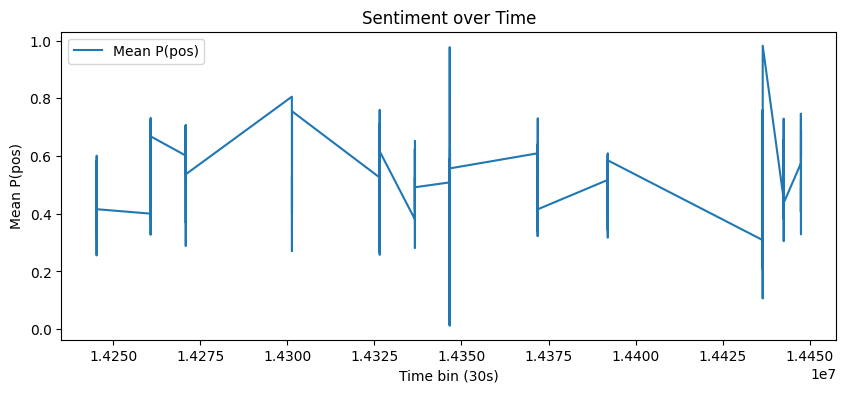

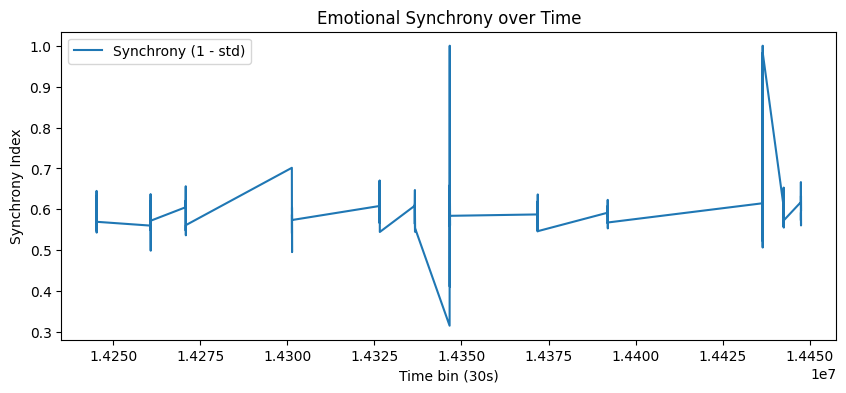

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

if df["ts"].notna().any():
    # 30초 bin (원하면 10/60초 등으로 바꿔도 됨)
    ts_df = df.dropna(subset=["ts"]).copy()
    ts_df["bin"] = (ts_df["ts"].astype("int64") // 10**9) // 120

    agg = ts_df.groupby("bin").agg(
        n=("clean_text","count"),
        mean_pos=("p_pos","mean"),
        std_pos=("p_pos","std")
    ).reset_index()
    agg["synchrony_idx"] = 1 - agg["std_pos"].fillna(0)

    display(agg.head())

    plt.figure(figsize=(10,4)); plt.plot(agg["bin"], agg["mean_pos"], label="Mean P(pos)")
    plt.ylabel("Mean P(pos)"); plt.xlabel("Time bin (30s)"); plt.title("Sentiment over Time"); plt.legend(); plt.show()

    plt.figure(figsize=(10,4)); plt.plot(agg["bin"], agg["synchrony_idx"], label="Synchrony (1 - std)")
    plt.ylabel("Synchrony Index"); plt.xlabel("Time bin (30s)"); plt.title("Emotional Synchrony over Time"); plt.legend(); plt.show()

    agg.to_csv("/content/timebins_sentiment_synchrony.csv", index=False)
else:
    print("타임스탬프가 없어서 시계열/동조도를 건너뜁니다.")

발표자료용 시각화 데이터

/tmp/ipython-input-1977761586.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_r["bin10"] = df_r["ts"].dt.floor("10T")


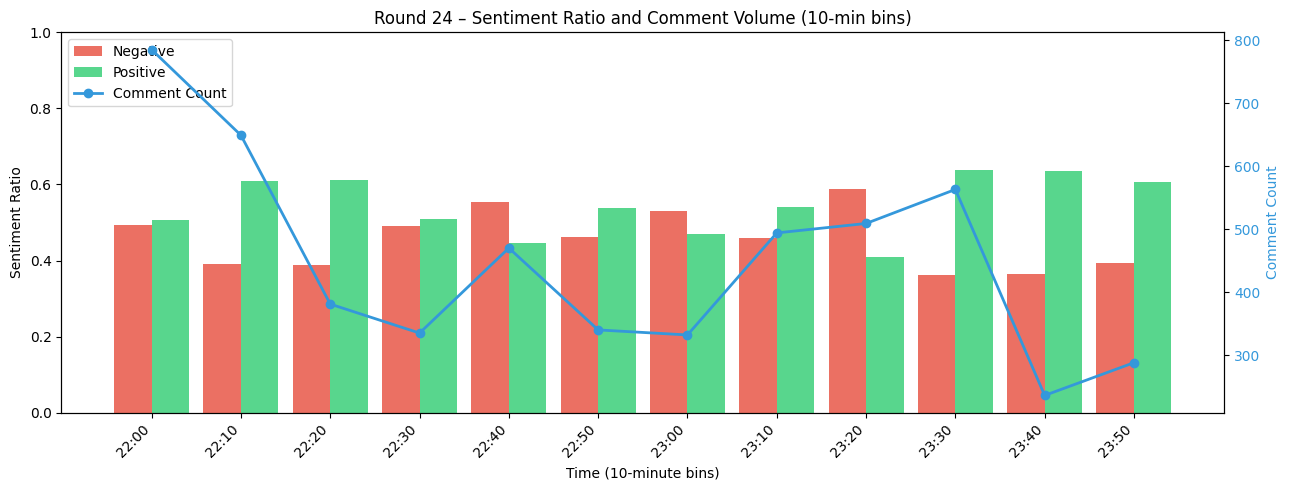

                     neg_ratio  pos_ratio  comment_count  neg_count  \
bin10                                                                 
2024-12-08 22:00:00   0.492994   0.507006            785        387   
2024-12-08 22:10:00   0.391371   0.608629            649        254   
2024-12-08 22:20:00   0.388451   0.611549            381        148   
2024-12-08 22:30:00   0.489552   0.510448            335        164   
2024-12-08 22:40:00   0.553191   0.446809            470        260   

                     pos_count  total_comments  
bin10                                           
2024-12-08 22:00:00        398             785  
2024-12-08 22:10:00        395             649  
2024-12-08 22:20:00        233             381  
2024-12-08 22:30:00        171             335  
2024-12-08 22:40:00        210             470  


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1️⃣ 특정 라운드 선택
round_target = 24
df_r = df[df["round_num"] == round_target].copy()

# 2️⃣ ts 컬럼이 datetime으로 되어 있는지 확인
if not np.issubdtype(df_r["ts"].dtype, np.datetime64):
    df_r["ts"] = pd.to_datetime(df_r["ts"], errors="coerce")

# 3️⃣ (선택) 중립 제외
if "neutral_flag" in df_r.columns:
    df_r = df_r[df_r["neutral_flag"] == 0]

# 4️⃣ 10분 단위 binning
df_r["bin10"] = df_r["ts"].dt.floor("10T")

# 5️⃣ 부정/긍정 카운트 및 비율 계산
counts = df_r.groupby(["bin10", "polarity_binary"]).size().unstack(fill_value=0)
for col in [0, 1]:
    if col not in counts.columns:
        counts[col] = 0
counts = counts.sort_index()
totals = counts.sum(axis=1).replace(0, np.nan)

props = pd.DataFrame({
    "neg_ratio": counts[0] / totals,
    "pos_ratio": counts[1] / totals,
    "comment_count": totals
}).fillna(0.0)

# 6️⃣ 그래프: 긍/부정 비율 막대 + 댓글 수 라인
x = np.arange(len(props))
width = 0.42
fig, ax1 = plt.subplots(figsize=(13, 5))

# 좌측 y축: 긍/부정 비율
ax1.bar(x - width/2, props["neg_ratio"], width, label="Negative", color="#e74c3c", alpha=0.8)
ax1.bar(x + width/2, props["pos_ratio"], width, label="Positive", color="#2ecc71", alpha=0.8)
ax1.set_ylabel("Sentiment Ratio")
ax1.set_ylim(0, 1)

# 우측 y축: 댓글 수
ax2 = ax1.twinx()
ax2.plot(x, props["comment_count"], color="#3498db", marker="o", label="Comment Count", linewidth=2)
ax2.set_ylabel("Comment Count", color="#3498db")
ax2.tick_params(axis="y", labelcolor="#3498db")

# 제목/축 설정
ax1.set_title(f"Round {round_target} – Sentiment Ratio and Comment Volume (10-min bins)")
ax1.set_xlabel("Time (10-minute bins)")
ax1.set_xticks(x)
ax1.set_xticklabels([t.strftime("%H:%M") for t in props.index], rotation=45, ha="right")

# 범례 합치기
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

plt.tight_layout()
plt.show()

# 7️⃣ 요약 데이터 테이블
summary = props.copy()
summary["neg_count"] = counts[0]
summary["pos_count"] = counts[1]
summary["total_comments"] = totals
print(summary.head())